Ce notebook contient 5 scripts python ces scripts assurent les deux grands parties de traitement de données :Feature Engineering & EDA pour les 5 datasets qu'on dispose (telemetry,errors,maint,failures,machines),ces scripts sont déjà verifier sous azure et ils ont montré le bon fonctionnement de toute le pipeline.

In [1]:
import pandas as pd
import os
data_path = r"C:\Users\Hinnovis\Downloads\Work_to_do\Work_to_do\Data"
os.chdir(data_path)


In [2]:
telemetry = pd.read_csv('telemetry.csv')
errors = pd.read_csv('errors.csv')
maint = pd.read_csv('maint.csv')
failures = pd.read_csv('failures.csv')
machines = pd.read_csv('machines.csv')

### Script N°1 :  Exploratory data analysis & Feature Engineering for telemetry data.

In [3]:
def azureml_main(telemetry):
    
    ## Require libs
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np   
    ##----------------------------------------------------------------------------
    # format datetime field which comes in as.character
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], infer_datetime_format=True)
    
    # volt data visualisation for machine ID=1 between '2015-01-01' and '2015-02-01'
    # the parametre "Azure" is to save the plot object in a file with a unique name specified.(if Azure set to False no plot saved) 
    # The contents of this file will be displayed at the Python device port of the Execute Python Script module
    Azure=True 
    plot_df = telemetry.loc[(telemetry['machineID'] == 1) & 
                           (telemetry['datetime'] > pd.to_datetime('2015-01-01')) & 
                           (telemetry['datetime'] <pd.to_datetime('2015-02-01')),
                           ['datetime','volt']]
    fig=plt.figure(figsize=(20, 8))
    plt.plot(plot_df['datetime'], plot_df['volt'])
    plt.ylabel('voltage')
    # make x-axis ticks legible
    adf = plt.gca().get_xaxis().get_major_formatter()
    adf.scaled[1.0] = '%m-%d-%Y'
    plt.xlabel('Date')
    plt.show()
    if(Azure == True): fig.savefig('figure')

    ##-------------------------------------------------------------------------
    ## Feature engineering
    ## Calculate the rolling mean and rolling standard deviation on the 
    ## last 3 hour lag window (width=3), for every 3 hours (by=3)
    ## for each machine ID.telemetrymean <- telemetry %>% 
    fields = ['volt', 'rotate', 'pressure', 'vibration']
    temp1= []
    temp2=[]
    temp3= []
    temp4=[]
    # Calculate mean values for telemetry features
    for col in fields:
        temp1.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
    telemetry_mean_3h = pd.concat(temp1, axis=1)
    telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
    telemetry_mean_3h.reset_index(inplace=True)
    # repeat for standard deviation
    for col in fields:
        temp2.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
    telemetry_sd_3h = pd.concat(temp2, axis=1)
    telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
    telemetry_sd_3h.reset_index(inplace=True)

    #For capturing a longer term effect, 24 hour lag features are also calculated as below
    #temp.append(pd.rolling_mean(, window=24)
    for col in fields:            
        ts_log= pd.pivot_table(telemetry,
                        index='datetime',
                        columns='machineID',
                        values=col)
        moving_avg = ts_log.rolling(24).mean()
        temp3.append(moving_avg.resample('3H',
                            closed='left',
                            label='right').first().unstack())           
    telemetry_mean_24h = pd.concat(temp3, axis=1)
    telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
    telemetry_mean_24h.reset_index(inplace=True)
    telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

    # repeat for standard deviation
    #temp.append(pd.rolling_mean(, window=24)
    for col in fields:   
        ts_log= pd.pivot_table(telemetry,
                    index='datetime',
                    columns='machineID',
                    values=col)
        moving_avg = ts_log.rolling(24).std()
        temp4.append(moving_avg.resample('3H',
                        closed='left',
                        label='right').first().unstack())           
    telemetry_sd_24h = pd.concat(temp4, axis=1)
    telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
    telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
    telemetry_sd_24h.reset_index(inplace=True)

    # merge columns of feature sets created earlier
    telemetry_feat = pd.concat([telemetry_mean_3h,
                                telemetry_sd_3h[telemetry_sd_3h.columns[2:6]],
                                telemetry_mean_24h[telemetry_mean_24h.columns[2:6]],
                                telemetry_sd_24h[telemetry_sd_24h.columns[2:6]]], axis=1).dropna()

    return telemetry_feat


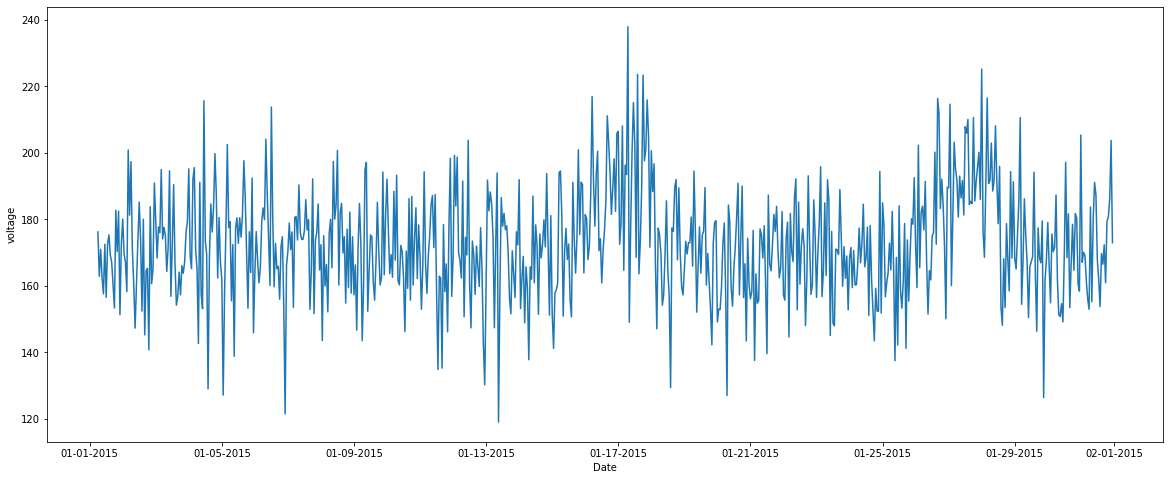

In [4]:
telemetry_feat=azureml_main(telemetry)

### Script N°2 :  Exploratory data analysis & Feature Engineering for errors data.

In [5]:
def azureml_main(errors,telemetry):
    
    ## Require libs
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # format datetime field which comes in as character
    telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], infer_datetime_format=True)
    errors['datetime'] = pd.to_datetime(errors['datetime'],infer_datetime_format=True)
    errors['errorID'] = errors['errorID'].astype('category')
    
    Azure = True
    # Visualisation
    fig = plt.figure(figsize=(15, 6))
    fig.clf()
    errors['errorID'].value_counts().plot(kind='bar')
    plt.ylabel('Count')
    plt.show()
    if(Azure == True): fig.savefig('errors figure')


    # create a column for each error type
    error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
    error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

    # combine errors for a given machine in a given hour (sum the duplicate errors in an hour)
    error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()

    #merge the tow dataset "telemetry" and "error_count" on ['machineID', 'datetime'] left and  replace the missing values.
    error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)

    #### Count the number of errors of different types in the last 24 hours
    temp = []
    fields = ['error%d' % i for i in range(1,6)]
    for col in fields:            
        ts_log= pd.pivot_table(error_count,
                                     index='datetime',
                                     columns='machineID',
                                     values=col)
        moving_sum = ts_log.rolling(24).sum()
        temp.append(moving_sum.resample('3H',
                            closed='left',
                            label='right').first().unstack())           

    error_count = pd.concat(temp, axis=1)
    error_count.columns = [i + 'count' for i in fields]
    error_count.reset_index(inplace=True)
    error_count = error_count.dropna()
    error_count.describe()
    
    # rename the final error dataset
    errorfeat=error_count

    return errorfeat

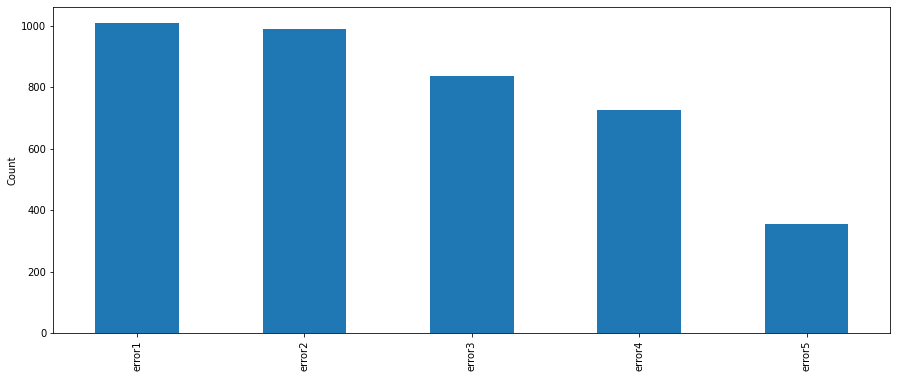

In [6]:
error_count=azureml_main(errors,telemetry)

### Script N°3 :  Exploratory data analysis & Feature Engineering for maintenance data.

In [7]:
def azureml_main(maint,telemetryfeat):
    
    ## Require libs
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np


    ##-------------------------------------------------------------------------
    # format datetime and comp fields
    maint['datetime'] = pd.to_datetime(maint['datetime'],infer_datetime_format=True)
    maint['comp'] = maint['comp'].astype('category')

    # Visualize the count of components
    # the parametre "Azure" is to save the plot object in a file with a unique name specified.
    Azure=True
    fig=plt.figure(figsize=(10, 4))
    maint['comp'].value_counts().plot(kind='bar')
    plt.ylabel('Count')
    plt.show()
    if(Azure == True): fig.savefig('maint figure')

    # create a column for each error type
    comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
    comp_rep.columns = ['datetime','machineID','comp1', 'comp2', 'comp3', 'comp4']

    # combine repairs for a given machine in a given hour
    comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

    # add timepoints where no components were replaced
    comp_rep = telemetryfeat[['datetime', 'machineID']].merge(comp_rep,
                                                          on=['datetime', 'machineID'],
                                                          how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in components:
        # convert indicator to most recent date of component change
        comp_rep.loc[comp_rep[comp] < 1, comp] = None
        comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
        # forward-fill the most-recent date of component change
        comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

    # remove dates in 2014 (may have NaN or future component change dates)    
    comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]
    components = ['comp1', 'comp2', 'comp3', 'comp4']
    for comp in components:
        comp_rep[comp]=(comp_rep['datetime'].sub(comp_rep[comp]))/np.timedelta64(1, 'D')    

    # replace dates of most recent component change with days since most recent component change
    comp_rep["datetime"],comp_rep["machineID"]=comp_rep["machineID"],comp_rep["datetime"]
    comp_rep.columns = ['machineID','datetime','comp1', 'comp2', 'comp3', 'comp4']
    
    return comp_rep

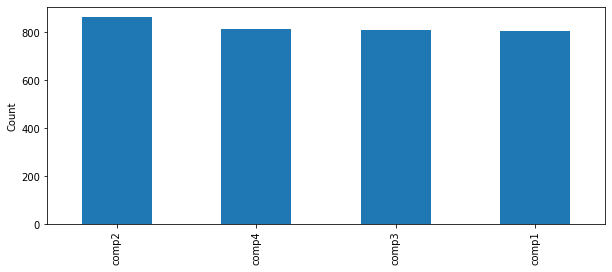

In [8]:
comp_rep=azureml_main(maint,telemetry_feat)
    

In [9]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')

### Script N°4 :  Exploratory data analysis & Feature Engineering for machines data.

In [10]:
def azureml_main(machines,final_feat):
    ##-------------------------------------------------------------------------
    ## Require libs
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    ##-------------------------------------------------------------------------
    # format model field
    
    machines['model'] = machines['model'].astype('category')
    
    # Visualize the count of errors
    # the parametre "Azure" is to save the plot object in a file with a unique name specified.
    Azure = True
    fig=plt.figure(figsize=(15, 6))
    _, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                           machines.loc[machines['model'] == 'model2', 'age'],
                           machines.loc[machines['model'] == 'model3', 'age'],
                           machines.loc[machines['model'] == 'model4', 'age']],
                           20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
    plt.xlabel('Age (yrs)')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    if(Azure == True): fig.savefig(' models Machines figure ')

    ##-------------------------------------------------------------------------
    final_feat = final_feat.merge(machines, on=['machineID'], how='left')

    return final_feat

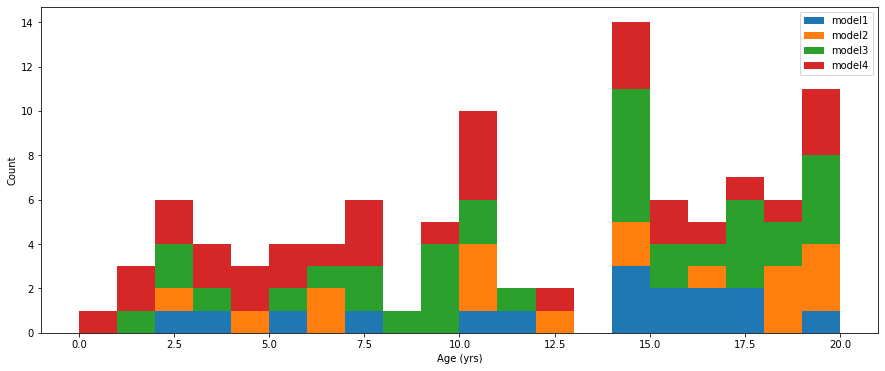

In [11]:
final_feat=azureml_main(machines,final_feat)

### Script N°5 :  Exploratory data analysis & Feature Engineering for failure data.

In [12]:

def azureml_main(failures,final_feat):
    
    #import libraries
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # format datetime field which comes in as.character
    # format datetime field which comes in as string
    failures['datetime'] = pd.to_datetime(failures['datetime'],infer_datetime_format=True)
    failures['failure'] = failures['failure'].astype('category')

    # Visualize the count of failures
    # the parametre "Azure" is to save the plot object in a file with a unique name specified.
    Azure = True
    fig = plt.figure(figsize=(15, 6))
    fig.clf()
    failures['failure'].value_counts().plot(kind='bar')
    plt.ylabel('Count')
    plt.show()
    if(Azure == True): fig.savefig('failures components figure')
     
    ##-------------------------------------------------------------------------
    # left join final features with failures on machineID then mutate a column for datetime difference
    # filter date difference for the prediction horizon which is 24 hours

    labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
    labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
    labeled_features =labeled_features.replace({np.NAN: None})
 
    ##-------------------------------------------------------------------------
    fig=plt.figure(figsize=(15, 6))
    labeled_features['failure'].value_counts().plot(kind='bar')
    plt.xlabel('Component failing')
    plt.ylabel('Count')
    fig.savefig('Component failing')

    return labeled_features

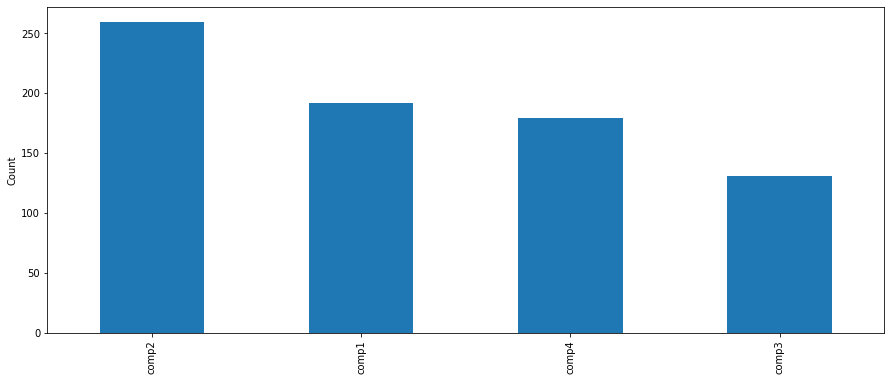

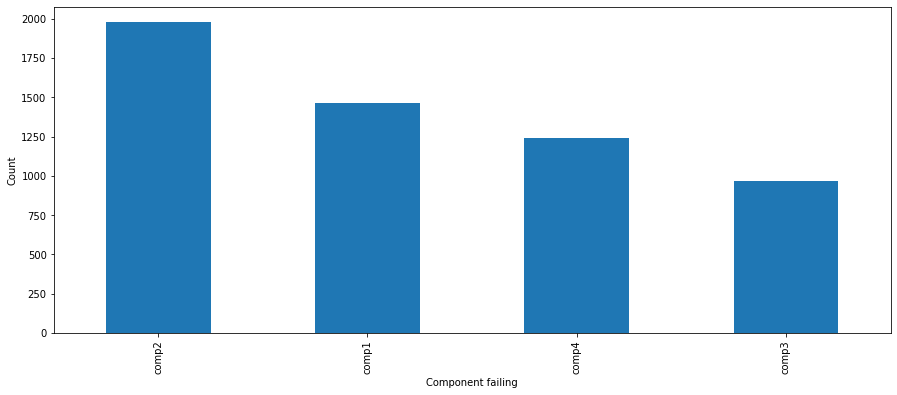

In [13]:
labeled_features=azureml_main(failures,final_feat)

In [18]:
labeled_features["failure"].value_counts()

comp2    1977
comp1    1464
comp4    1240
comp3     968
Name: failure, dtype: int64